# Default Risk Model and Credit Scoring
### Author: Ángel Manuel Gálvez Límaco
#### Objetive: Predict the probability that somebody will experience financial distress in the next two years and propose a credit score  approach.

Importing the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
#from optbinning import BinningProcess
#from optbinning import Scorecard
#from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice
import seaborn as sns
import imblearn
from tabulate import tabulate
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from fast_ml.feature_selection import get_constant_features

Reading the dataset:

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\Asus\Desktop\desafio\desafio_cloudwalk\data\training_data.csv')

In [3]:
df.head(4)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0


## Exploratory Data Analysis (EDA) of the original dataset

In [4]:
df['Unnamed: 0'].nunique()

150000

The first observation is that the first column corresponds to a client ID column, so we can drop it since is irrelevant to our predictive model:

In [5]:
df.drop(columns = df.columns[0], inplace = True)

In [6]:
df.shape

(150000, 11)

This dataset contains 150000 rows and 11 features. 

In [7]:
print('Our target feature is', df.columns[0], '.')

Our target feature is SeriousDlqin2yrs .


In [8]:
df[df.columns[0]].value_counts(normalize = True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

The dataset is highly imbalanced: 93.32% of entries possess ‘SeriousDlqin2yrs’=0, being the majority class, while barely 6.68% of rows correspond to the case of a high risk credit operation, i.e., ‘SeriousDlqin2yrs’=1. Therefore, this is a classification problem where a loan rejection is considered an anomaly since represents a high risk for the company.

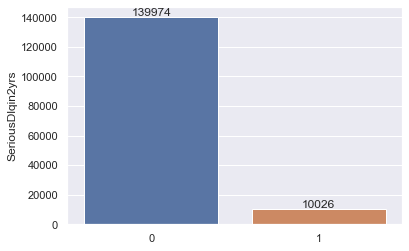

In [9]:
#Barplot of the target
sns.set(rc={'figure.figsize':(6,4)})
sns.set(font_scale = 1)
ax = sns.barplot(y = df['SeriousDlqin2yrs'].value_counts(), x=[0,1], orient = 'v')
for i in ax.containers:
    ax.bar_label(i,);

In [10]:
#Checking missing data
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

The features 'MonthlyIncome' and 'NumberofDependents' present missing data.

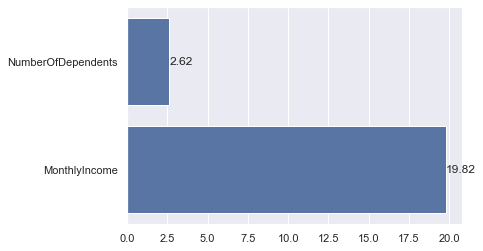

In [11]:
#Bar plot of the percentage of missing values
dic_na = {}
tmp = 0
for i in range(len(df.columns)):
    if df[df.columns[i]].isnull().sum()/df.shape[0]>0:
        dic_na[df.columns[i]] = round(df[df.columns[i]].isnull().sum()*100/df.shape[0], 2)
        tmp = tmp+1
dic_na = dict(sorted(dic_na.items(), key = lambda item: item[1]))

sns.set(rc={'figure.figsize':(6,4)})
sns.set(font_scale = 1)
ax = sns.barplot(y = list(dic_na.keys()), x = list(dic_na.values()), orient = 'h', color = 'b')
for i in ax.containers:
    ax.bar_label(i,)

In [12]:
print('The features ''MonthlyIncome'' and ''NumberOfDependents'' present', round(df['MonthlyIncome'].isna().sum()*100/df.shape[0],2),'% and', round(df['NumberOfDependents'].isna().sum()*100/df.shape[0],2),'% of missing data, respectively.')

The features MonthlyIncome and NumberOfDependents present 19.82 % and 2.62 % of missing data, respectively.


An imputation methodology will be adopted to replace the missing values.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

All features are numeric.

In [14]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


We observe some interesting facts about our dataset:
- There are some individuals who have 20 dependents, that is quite high for a regular modern family. On the other hand, the average number of dependents is less than 1, 0.75.
- There are clients who are 0 years old, which seems impossible since a loan has to be requested by individuals who have reached at least the majority of age. We will treat these rows as outliers. Also, there are clients who are 109 years old and, thus, they clearly represent a risk to the loan company due to the uncertainty in the future payments.
- Some requesters have MonthlyIncome=0, which is remarkable since, commonly, loans are granted to people who are able to pay it in the future. On the other hand, there are individuals with extremely high Monthly Incomes when compared to the mean and they will be seen as outliers. Probably, a transformation will be needed to treat the distribution if the number of outliers is high.
- By taking a look at the values of the maximum values, means and medians, we can expect that most of the features present highly skewed distributions.
- Curiously, the features NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate have 98 as their maximum value. This number might be a code of a related information. A feature binning could be the best solution.

Obtaining the number of duplicated rows:

In [15]:
df[df.duplicated() == True].shape

(609, 11)

There are 609 duplicated rows. They will be removed since they do not provide new relevant information to our model.

In [16]:
#Dropping duplicated rows
df.drop_duplicates(inplace = True)

In [17]:
df.shape

(149391, 11)

As a consequence, we now have 149391 entries to develop our predictive model.

Let us take a look at the distributions of the features:

<AxesSubplot:xlabel='NumberOfTimes90DaysLate', ylabel='Count'>

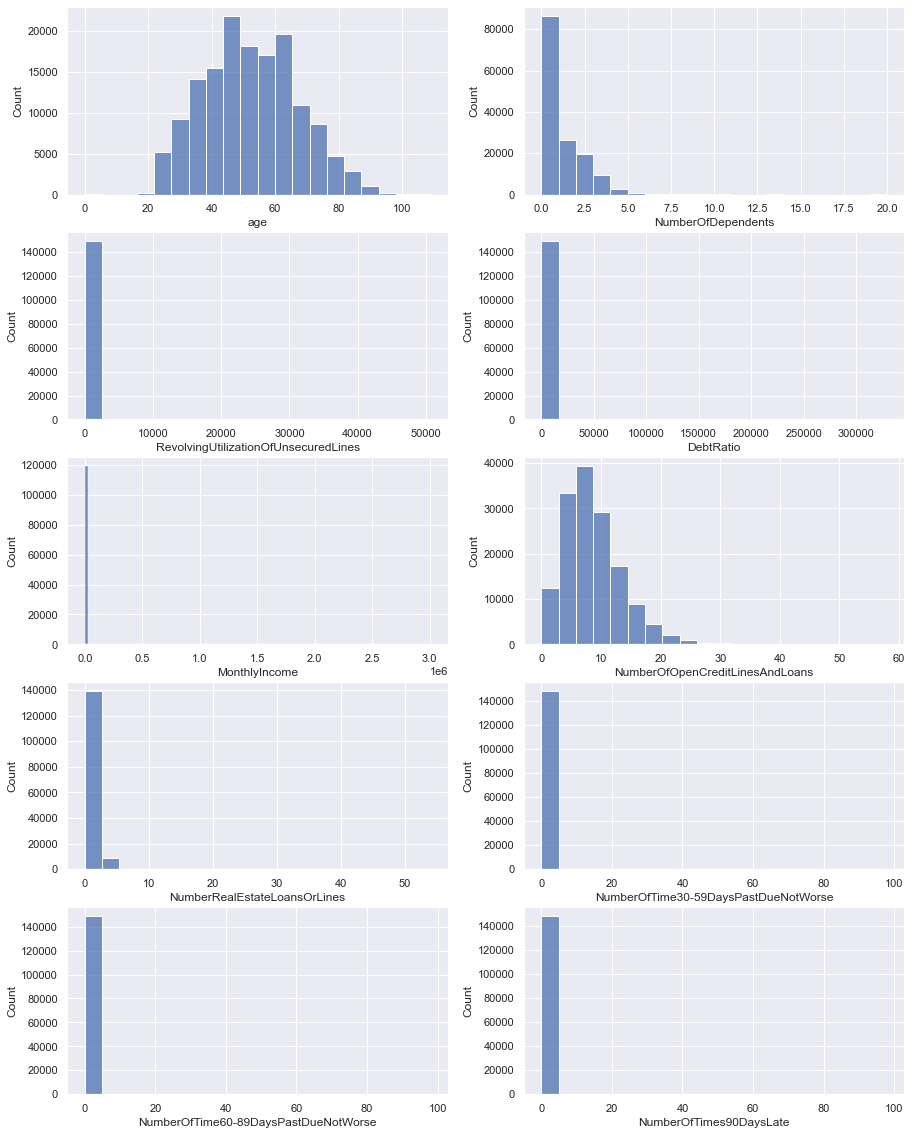

In [18]:
sns.set(rc={'figure.figsize':(15,20)})
sns.set(font_scale = 1)
f, axes = plt.subplots(5, 2)
sns.histplot(data = df, x = 'age', color = 'b', bins = 20, ax = axes[0,0])
sns.histplot(data = df, x = 'NumberOfDependents', color = 'b', bins = 20, ax = axes[0,1])
sns.histplot(data = df, x = 'RevolvingUtilizationOfUnsecuredLines', color = 'b', bins = 20, ax = axes[1,0])
sns.histplot(data = df, x = 'DebtRatio', color = 'b', bins = 20, ax = axes[1,1])
sns.histplot(data = df, x = 'MonthlyIncome', color = 'b', bins = 100, ax = axes[2,0])
sns.histplot(data = df, x = 'NumberOfOpenCreditLinesAndLoans', color = 'b', bins = 20, ax = axes[2,1])
sns.histplot(data = df, x = 'NumberRealEstateLoansOrLines', color = 'b', bins = 20, ax = axes[3,0])
sns.histplot(data = df, x = 'NumberOfTime30-59DaysPastDueNotWorse', color = 'b', bins = 20, ax = axes[3,1])
sns.histplot(data = df, x = 'NumberOfTime60-89DaysPastDueNotWorse', color = 'b', bins = 20, ax = axes[4,0])
sns.histplot(data = df, x = 'NumberOfTimes90DaysLate', color = 'b', bins = 20, ax = axes[4,1])


As it was expected, most of the features are highly skewed to the right. The ''most normally distributed'' feature is age.

In [19]:
df.age.describe()

count    149391.000000
mean         52.306237
std          14.725962
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [20]:
df[df.age==0]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


It is observed that there is a request from a client with an age of 0 years old, which is quite strange. This client was approved to receive a loan and has a monthly income of 6000 and 2 dependents. The easiest decision would be to drop this line if we consider an age of zero as invalid. However, another choice would be to impute the age with, for example, the median of the distribution.

In [21]:
df[df.age==109]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
105790,0,0.109307,109,0,2141.0,NaN,17,0,1,0,NaN
138291,0,0.246529,109,0,318.0,NaN,3,0,0,0,NaN


Surprisingly, there are senior citizens with an age of 109 years old who have SeriousDlqin2yrs=0. In addition, these individuals are missing both the number of dependents and their monthly income.

Three features are almost constant, roughly 94% of the rows have the same value. For example, considering the feature 'NumberOftimes90DaysLate', most of its values are zero, meaning that 94,44% of the loan requests were made by individuals who were not late more than 90 days in a past due.

In [22]:
get_constant_features(df, threshold = 0.9, dropna = True)

,Desc,Var,Value,Perc
0,Quasi Constant,NumberOfTime60-89DaysPastDueNotWorse,0,94.939454
1,Quasi Constant,NumberOfTimes90DaysLate,0,94.455489
2,Quasi Constant,SeriousDlqin2yrs,0,93.300132


Let us use the boxplots to visualize the outliers of our features:

<AxesSubplot:xlabel='SeriousDlqin2yrs', ylabel='NumberOfDependents'>

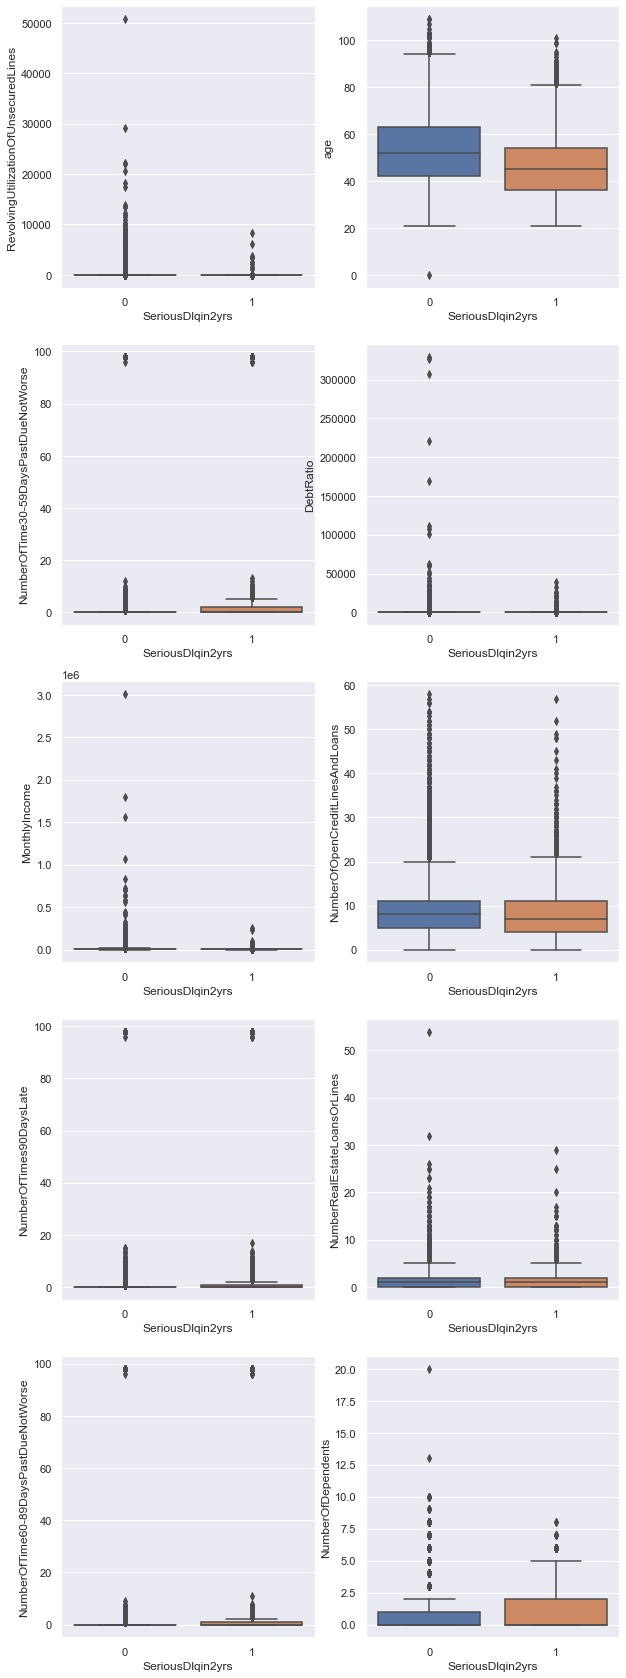

In [23]:
sns.set(rc={'figure.figsize':(10,30)})
sns.set(font_scale = 1)
f, axes = plt.subplots(5, 2)
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines', ax = axes[0,0])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='age', ax = axes[0,1])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberOfTime30-59DaysPastDueNotWorse', ax = axes[1,0])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='DebtRatio', ax = axes[1,1])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='MonthlyIncome', ax = axes[2,0])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberOfOpenCreditLinesAndLoans', ax = axes[2,1])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberOfTimes90DaysLate', ax = axes[3,0])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberRealEstateLoansOrLines', ax = axes[3,1])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberOfTime60-89DaysPastDueNotWorse', ax = axes[4,0])
sns.boxplot(data=df, x='SeriousDlqin2yrs', y='NumberOfDependents', ax = axes[4,1])

Also, let us see the empirical relationship between features by using bivariate analysis:

<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='NumberOfTimes90DaysLate'>

C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


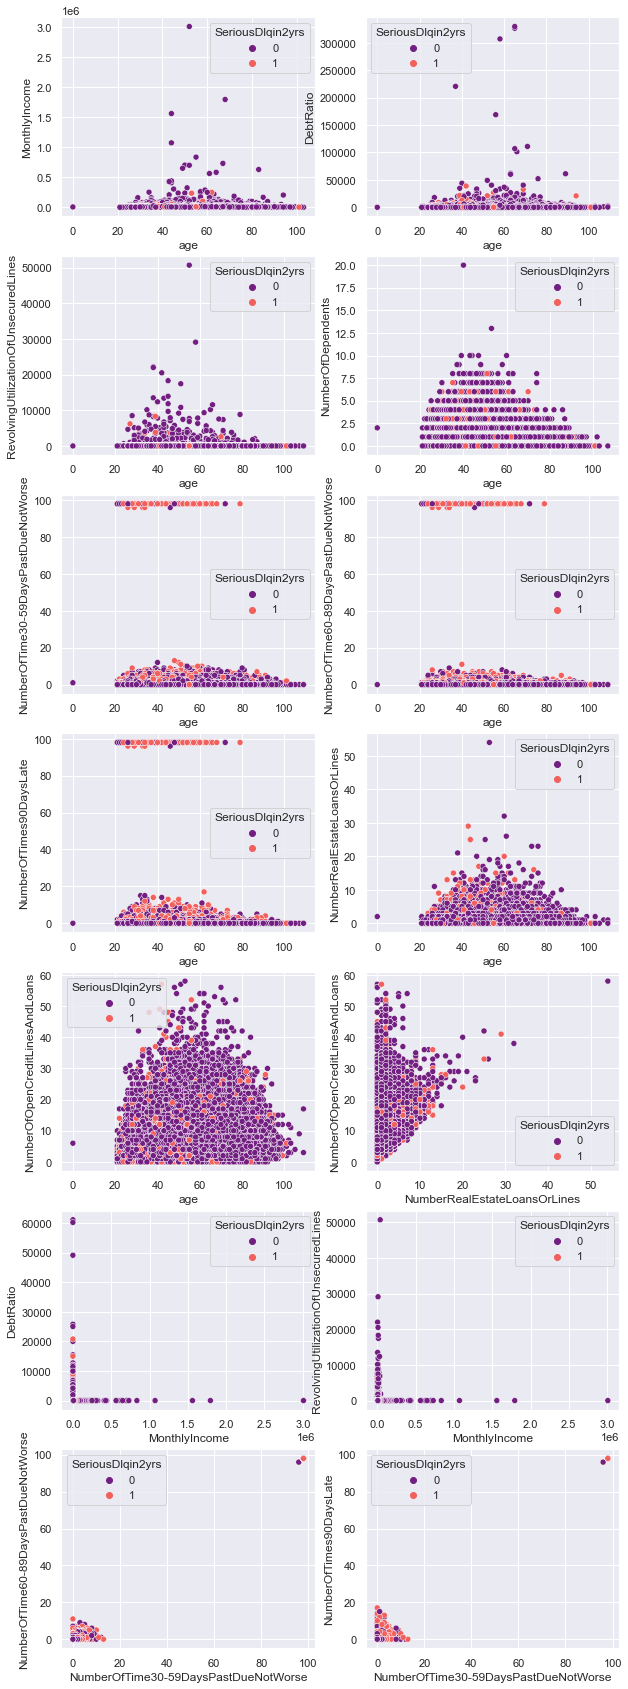

In [24]:
sns.set(rc={'figure.figsize':(10,30)})
f, axes = plt.subplots(7, 2)
sns.set(font_scale=1)
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='MonthlyIncome', palette = 'magma', ax = axes[0,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='DebtRatio', palette = 'magma', ax = axes[0,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='RevolvingUtilizationOfUnsecuredLines', palette = 'magma', ax = axes[1,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberOfDependents', palette = 'magma', ax = axes[1,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberOfTime30-59DaysPastDueNotWorse', palette = 'magma', ax = axes[2,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberOfTime60-89DaysPastDueNotWorse', palette = 'magma', ax = axes[2,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberOfTimes90DaysLate', palette = 'magma', ax = axes[3,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberRealEstateLoansOrLines', palette = 'magma', ax = axes[3,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='age', y='NumberOfOpenCreditLinesAndLoans', palette = 'magma', ax = axes[4,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='NumberRealEstateLoansOrLines', y='NumberOfOpenCreditLinesAndLoans', palette = 'magma', ax = axes[4,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='MonthlyIncome', y='DebtRatio', palette = 'magma', ax = axes[5,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='MonthlyIncome', y='RevolvingUtilizationOfUnsecuredLines', palette = 'magma', ax = axes[5,1])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='NumberOfTime30-59DaysPastDueNotWorse', y='NumberOfTime60-89DaysPastDueNotWorse', palette = 'magma', ax = axes[6,0])
sns.scatterplot(data=df, hue = df['SeriousDlqin2yrs'], x='NumberOfTime30-59DaysPastDueNotWorse', y='NumberOfTimes90DaysLate', palette = 'magma', ax = axes[6,1])

From the boxplots and the bivariate analysis, we can afirm that:
- By taking a look at the boxplots, we can expect a high amount of outliers so that removing them might not be the best option since we can lose relevant information.
- People aged between 40 and 60 years tend to have a higher number of dependents when compared to other ages.
- It is clear that when an individual has been behind in paying a debt for more than 30, 60 or 90 days, it is unlikely that they will be approved for a new loan since they represent a high risk.
- Surprisingly, there are some clients who were late in the payment of a due for more than 90 days, and yet they were approved for a loan. But, in general, a bad client's payment behaviour implies low chances to acquire a loan.
- Young people and senior citizens tend to have a small number of open credit lines and loans and real state loans or lines.
- The higher the monthly income of a person, the higher the chance of being approved for a loan.
- People aged between 40 and 70 years tend to have a higher monthly incomes when compared to other ages.
- Additionally, people with higher monthly incomes have lower DebtRatio and RevolvingUtilizationofUnsecuredLines. This could mean that a person's debts are smaller compared to their salary.

Lastly, let us take a look at the correlation matrix:

<AxesSubplot:>

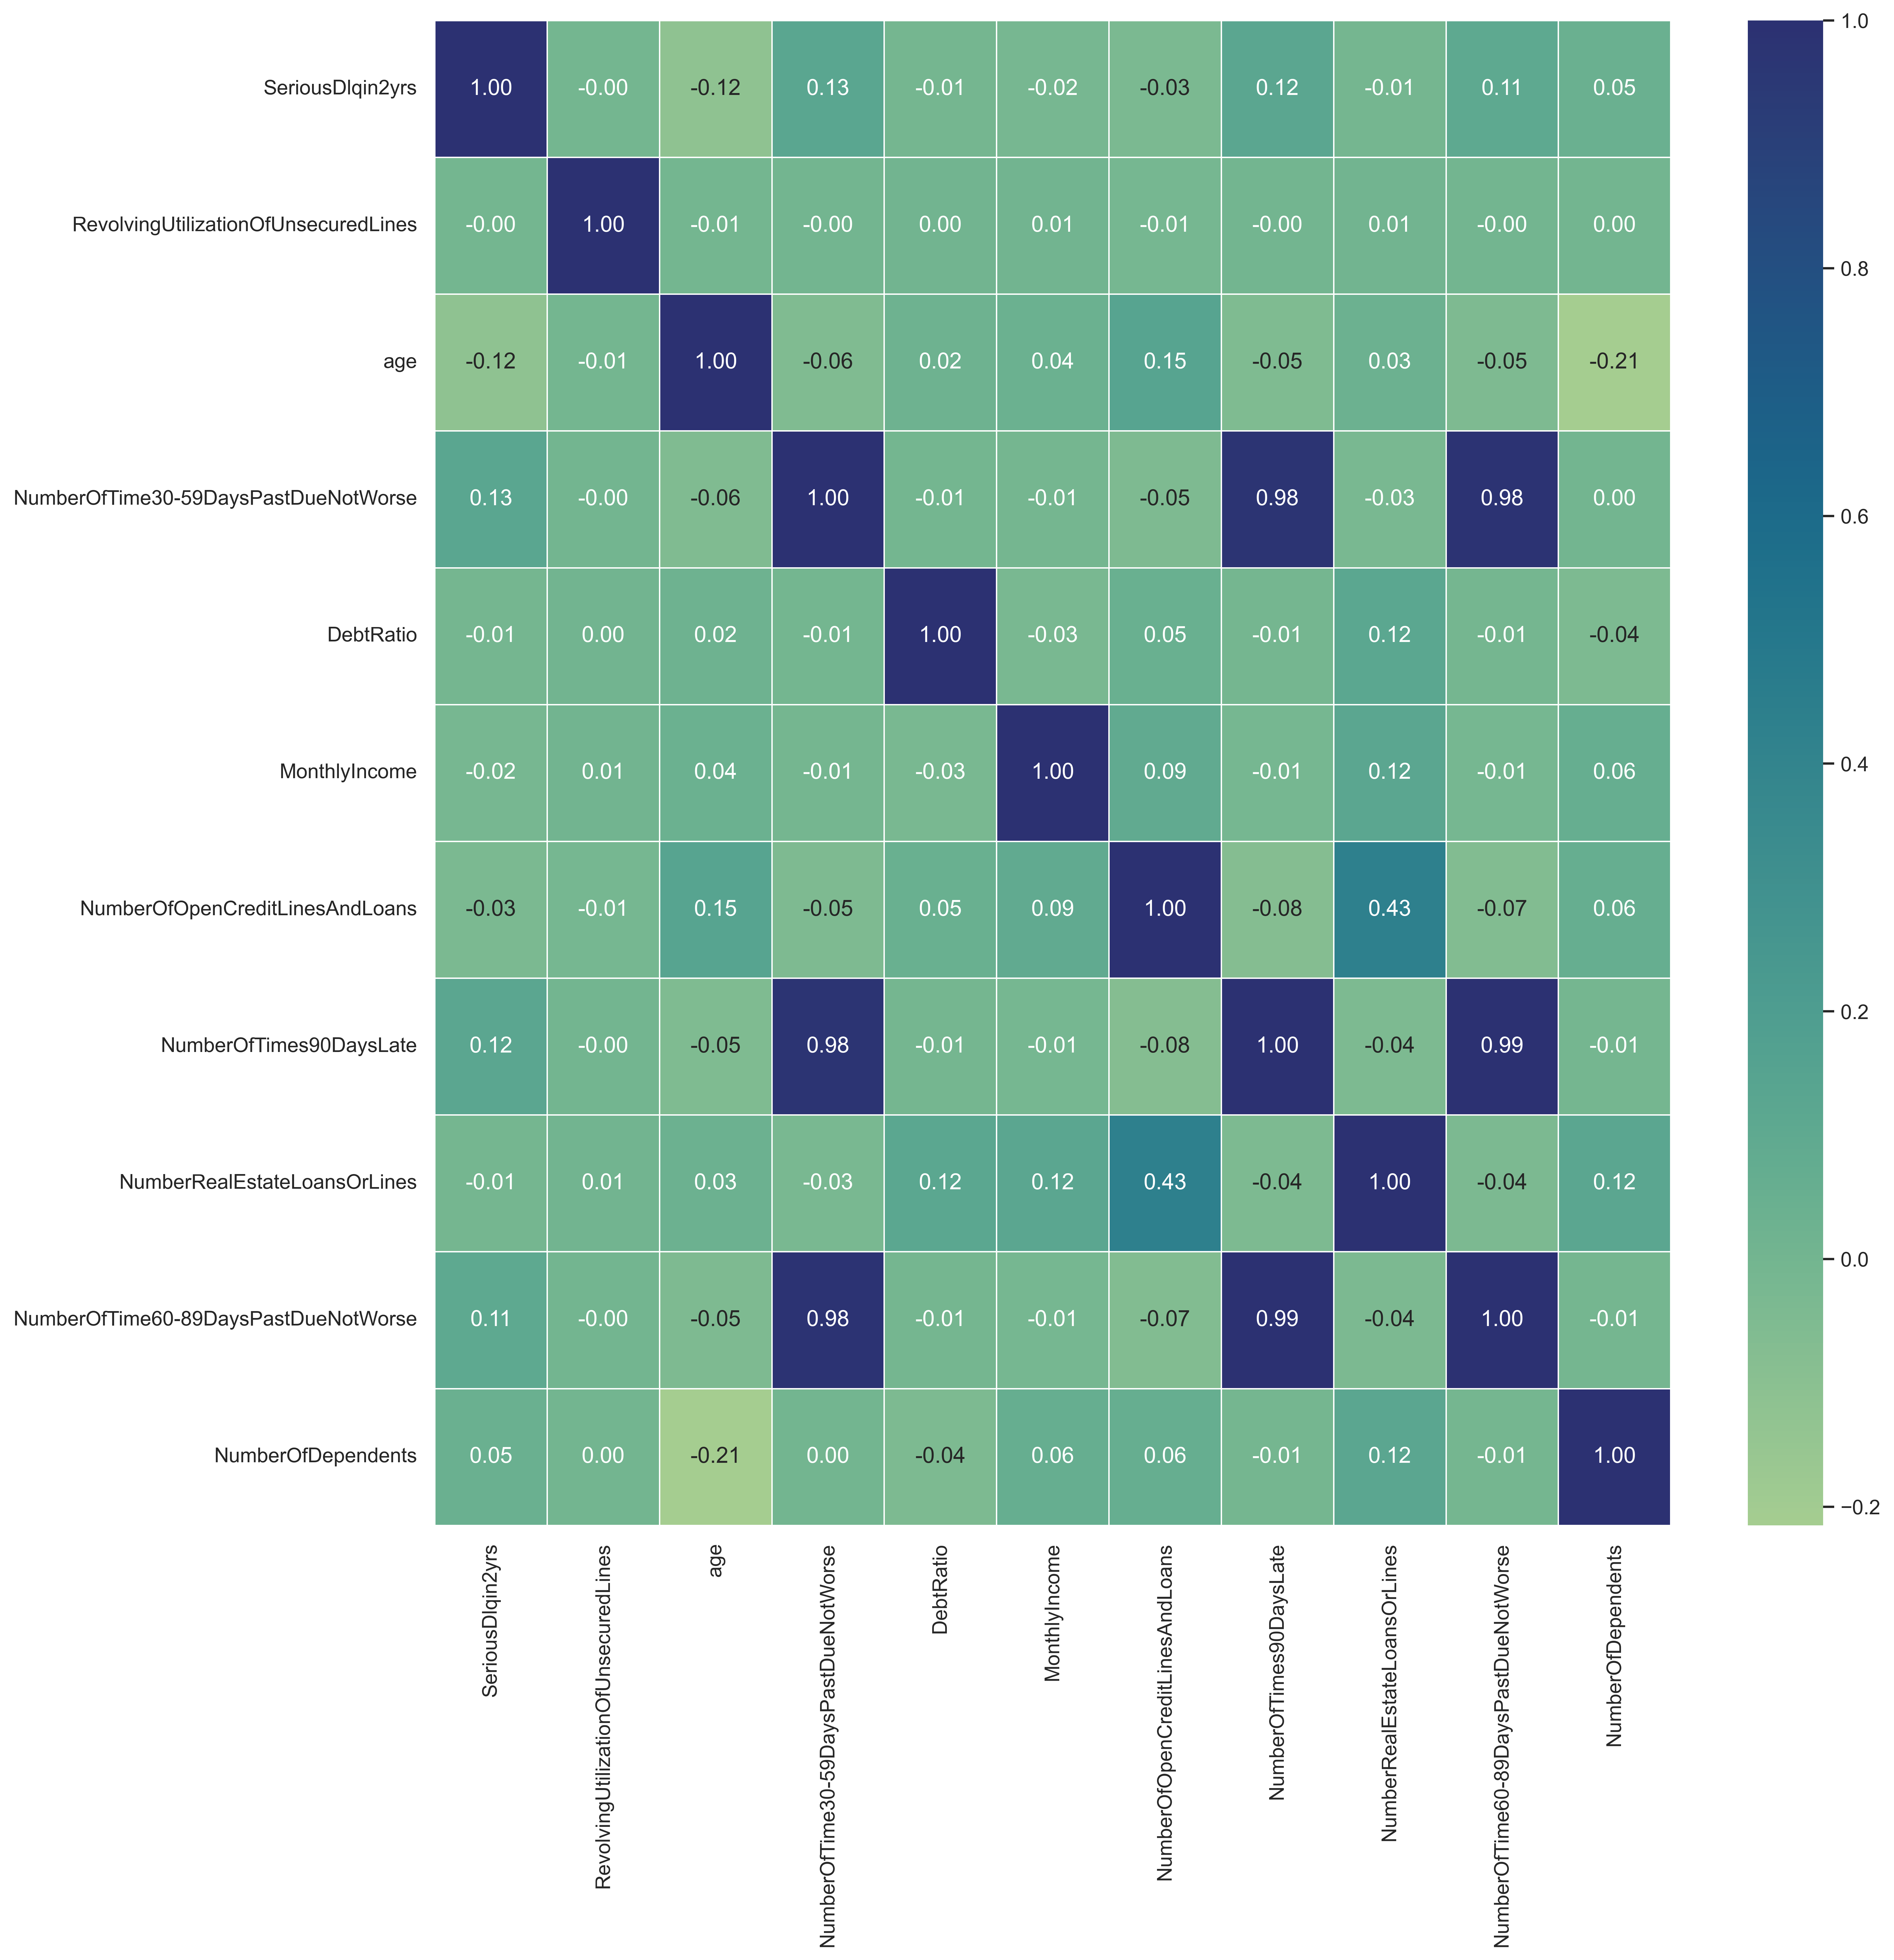

In [25]:
fig = plt.figure(figsize=(15,15), dpi = 480)
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=1)
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidth=.5, cmap = 'crest')

- A relatively high correlation between the features 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate' and the target 'SeriousDlqin2yrs' means that if a client already has been behind in paying a debt for more than 30 days, then most likely that they will not receive the loan.
- We observe an extremely high correlation between the features 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'. This could mean that if a client is in default between 30 and 59 days, then it is likely that they will also be in default for more than 60 days. Therefore, this client exhibits a bad behavior that represents a risk for the company. Perhaps use these 3 features for feature engineering.
- Negative correlation between the target and the features 'age', 'MonthlyIncome' and 'DebtRatio' shows that a young client with few debts and a high salary represents a low risk for the company and, thus, there are higher chances that a loan will be granted.

Once we have observed the nature of the dataset, let us calculate the number of outliers by using the Inter Quartile Range without considering the missing values:

In [26]:
#Selecting the features
cols = df.drop(columns = ['SeriousDlqin2yrs']).columns
total = 0
for column in cols:
    q1 = np.quantile(df.dropna(subset = column)[column], 0.25)
    q3 = np.quantile(df.dropna(subset = column)[column], 0.75)
    
    #IQR
    IQR = q3-q1
    #Ranges
    lower_range = q1 - 1.5*IQR
    higher_range = q3 + 1.5*IQR
    
    #Rows that are out of the range
    n = df.dropna(subset = column).shape[0]
    df_outliers = df[(df[column] > higher_range) | (df[column] < lower_range)]
    rows = df_outliers.shape[0]
    outliers = df_outliers.shape[0]*100/n
    print('The feature', column, 'presents', rows, 'outliers (', outliers,'%)')
    total = total + rows
print('Total number of outliers:', total)

The feature RevolvingUtilizationOfUnsecuredLines presents 769 outliers ( 0.5147565783748687 %)
The feature age presents 45 outliers ( 0.030122296523886982 %)
The feature NumberOfTime30-59DaysPastDueNotWorse presents 23938 outliers ( 16.023722981973478 %)
The feature DebtRatio presents 31285 outliers ( 20.941689927773428 %)
The feature MonthlyIncome presents 4878 outliers ( 4.059249396688025 %)
The feature NumberOfOpenCreditLinesAndLoans presents 3980 outliers ( 2.664149781446004 %)
The feature NumberOfTimes90DaysLate presents 8283 outliers ( 5.544510713496797 %)
The feature NumberRealEstateLoansOrLines presents 793 outliers ( 0.5308218031876084 %)
The feature NumberOfTime60-89DaysPastDueNotWorse presents 7560 outliers ( 5.060545816013013 %)
The feature NumberOfDependents presents 13336 outliers ( 9.161668830678126 %)
Total number of outliers: 94867


Since the number of outliers is quite high, we will not remove them. Instead, we will use feature engineering in order to change its values.

## Feature Engineering

Instead of dropping the row with age=0, we will replace this value with the mode of all clients who have 2 dependents and a monthly income of 6000.

In [27]:
df[(df.NumberOfDependents == 2) & (df.MonthlyIncome == 6000)]['age'].mode()

0    39
Name: age, dtype: int64

In [28]:
df['age'] = df['age'].replace(0, 39)

In [29]:
df.age.describe()

count    149391.000000
mean         52.306498
std          14.725380
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

Now the minimum age of requesters is 21 years.

By taking into account the definition of 'DebtRatio': 

To avoid data leakage, let us split the dataset into training and test sets in a stratified way so we can maintain the degree of imbalanced data. 20% of the original data will be used to test our predictive model.

In [30]:
#20% of the dataset will be used to evaluate the model
y = df['SeriousDlqin2yrs']
X = df.drop(columns='SeriousDlqin2yrs')
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
X_train = pd.DataFrame(X_train, columns = features)
X_test = pd.DataFrame(X_test, columns = features)

Since we already saw that the quantity of missing values of 'MonthlyIncome' and 'NumberOfDependents' is small, we will impute them by using the median.

In [31]:
median_imputer_1 = SimpleImputer(missing_values = np.nan, strategy = 'median')
median_imputer_2 = SimpleImputer(missing_values = np.nan, strategy = 'median')

#Fitting and transforming the feature 'MonthlyIncome'
median_imputer_1 = median_imputer_1.fit(X_train[['MonthlyIncome']])
X_train[['MonthlyIncome']] = median_imputer_1.transform(X_train[['MonthlyIncome']])

#Fitting and transforming the feature 'NumberOfDependents'
median_imputer_2 = median_imputer_2.fit(X_train[['NumberOfDependents']])
X_train[['NumberOfDependents']] = median_imputer_2.transform(X_train[['NumberOfDependents']])

Now our training set no longer has missing values:

In [32]:
X_train.isnull().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Next, from the histograms that were shown before, let us recall that 'MonthlyIncome', 'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberRealEstateLoansOrLines' and 'NumberOfOpenCreditLinesAndLoans' present right-skewed distributions over considerable ranges. Therefore, we will use the log(1+x) transformation to approximately conform to normality.

In [33]:
log_transform = ['MonthlyIncome', 'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
                'NumberRealEstateLoansOrLines']
for col in log_transform:
    X_train[col] = np.log(X_train[col] + 1)

Next, as discussed on the initial EDA, the highly correlated features, 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate' exhibit realistic values (less than 20). However, these features also present the values 96 and 98. Either these values are codes for a specific case or errors during the data acquisition, they are outliers that must be treated. In this way, let us say that we limit the values up to 6, being the worst scenario according to our company policy.

In [34]:
X_train['NumberOfTime30-59DaysPastDueNotWorse'] = np.where(X_train['NumberOfTime30-59DaysPastDueNotWorse'] > 6, 6,
                                                           X_train['NumberOfTime30-59DaysPastDueNotWorse'])
X_train['NumberOfTime60-89DaysPastDueNotWorse'] = np.where(X_train['NumberOfTime60-89DaysPastDueNotWorse'] > 6, 6,
                                                           X_train['NumberOfTime60-89DaysPastDueNotWorse'])
X_train['NumberOfTimes90DaysLate'] = np.where(X_train['NumberOfTimes90DaysLate'] > 6, 6, X_train['NumberOfTimes90DaysLate'])

## Feature Importance
Let us use a Random Forest Classifier to calcular the Feature Importance Score in oder to detect the most relevant features.

In [35]:
#Random Forest Classifier:
feature_importance_model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 7)
feature_importance_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=7)

In [36]:
#Saving the scores
importances = feature_importance_model.feature_importances_

#Ordered scores
indices = np.argsort(importances)
indices

array([7, 9, 8, 2, 6, 5, 1, 4, 3, 0], dtype=int64)

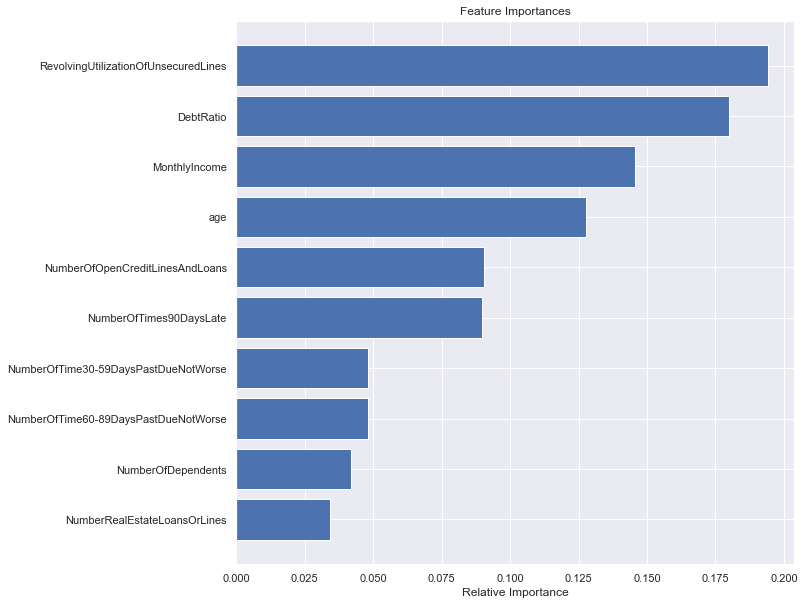

In [37]:
#Plotting
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
#plt.axvline(x=0.006, color='r', linewidth = '6', linestyle='dashed')
plt.xlabel('Relative Importance')
plt.show()

As it may seem intituive, the most important characteristics to evaluate if a loan requester represents a risk are their salary, past financial behavior, past debts and their age. 

## Normalization

The last step before using our preprocessed training set to compare the performance of serveral classification algortihs is the normalization of the features.

In [38]:
normalization = MinMaxScaler()
X_train = normalization.fit_transform(X_train)

## Preprocessing Pipeline
Recall that all the preprocessing steps were created from the training set to avoid data leakage. Therefore, if we want to test the performance of an algorithm, we must prepare the test data accordingly. The following function will do the job.

In [39]:
def preprocessing_data(X, imputer_1, imputer_2, log_cols, normalization):
    
    #Imputing data
    X[['MonthlyIncome']] = imputer_1.transform(X[['MonthlyIncome']])
    X[['NumberOfDependents']] = imputer_2.transform(X[['NumberOfDependents']])
    
    #Applying log transformation to specific columns
    for col in log_cols:
        X[col] = np.log(X[col] + 1)
    
    #Applying 
    X['NumberOfTime30-59DaysPastDueNotWorse'] = np.where(X['NumberOfTime30-59DaysPastDueNotWorse'] > 6, 6,
                                                        X['NumberOfTime30-59DaysPastDueNotWorse'])
    X['NumberOfTime60-89DaysPastDueNotWorse'] = np.where(X['NumberOfTime60-89DaysPastDueNotWorse'] > 6, 6,
                                                        X['NumberOfTime60-89DaysPastDueNotWorse'])
    X['NumberOfTimes90DaysLate'] = np.where(X['NumberOfTimes90DaysLate'] > 6, 6, X['NumberOfTimes90DaysLate'])
    
    #Applying normalization
    X = normalization.transform(X)
    
    return X

In [40]:
X_test = preprocessing_data(X_test, median_imputer_1, median_imputer_2, log_transform, normalization)

## Classification Algorithms
From 7 candidates, we wil choice the classification algorithm which has the best performance. Let us recall that an individual who actually presents a high default risk is considered by our model as a potential loan receiver, i.e., a False Negative (FN), may cause meaningful financial loss to the company. Therefore, our model must be able to efficiently distinguish between the classes of our target 'SeriousDlqin2yrs' so the amount of FN is minimized. A smaller FN will imply a higher True Positive Rate (TPR). Consequently, our chosen metric will be ROC-AUC. 

The candidate algorithms are: Decision Tree Classifier, Random Forest, Logistic Regression, Naive Bayes, k Neighbors Classifier, AdaBoost and XGBoost Classifier.

Let us begin by defining a plot function that will be useful. AUC curve enables to visualize how well our machine learning model is performing classification.

In [41]:
#Plotting the ROC curve
def plot_roc(prob, y_hat):
    #obtaining fpr, tpr and the corresponding thresholds
    preds = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_hat, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    #plotting
    plt.figure(figsize=(6,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Decision Tree Classifier
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [42]:
hyperparameters = { 'criterion': ['gini','entropy'], 'max_depth': np.arange(5, 15), 'max_features': ['auto', 'sqrt', 'log2']}
algorithm = DecisionTreeClassifier(random_state = 7) 
clf_decision_tree = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_decision_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='roc_auc')

In [43]:
print('The hyperparameters are:', clf_decision_tree.best_params_)

The hyperparameters are: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}


Using these hyperparameters to train our Decision Tree Classifier:

In [44]:
decision_tree = DecisionTreeClassifier(criterion = clf_decision_tree.best_params_['criterion'],
                                       max_depth = clf_decision_tree.best_params_['max_depth'],
                                       max_features = clf_decision_tree.best_params_['max_features'], random_state=7)
decision_tree.fit(X_train, y_train)

y_pred_decision_tree = decision_tree.predict(X_train)
confusion_matrix_decision_tree = confusion_matrix(y_train, y_pred_decision_tree)
print('The ROC-AUC score for the Decision Tree Classifier is', roc_auc_score(y_train, decision_tree.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the Decision Tree Classifier is 0.8578446557571618


Text(0.5, 1.0, 'Confusion matrix of the training set for Decision Tree Classifier')

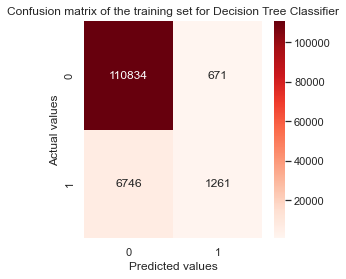

In [45]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_decision_tree, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Decision Tree Classifier')

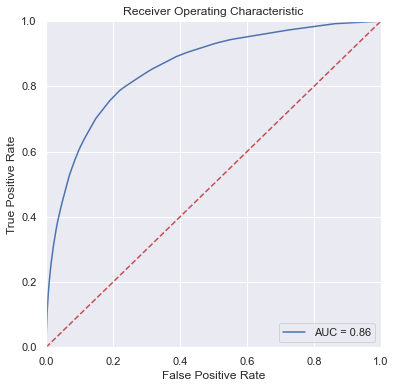

In [46]:
plot_roc(decision_tree.predict_proba(X_train), y_train)

#### Random Forest
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [47]:
hyperparameters = {'n_estimators': [250, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10,100],
                   'criterion': ['gini', 'entropy']}
algorithm = RandomForestClassifier(random_state = 7, n_jobs = -1) 
clf_random_forest = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', verbose = 2, cv = 5)
clf_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=250; total time=  10.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=250; total time=  10.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=250; total time=  11.4s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=250; total time=  10.7s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=250; total time=  10.9s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500; total time=  22.4s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500; total time=  23.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500; total time=  20.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500; total time=  21.4s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500; total ti

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [250, 500]},
             scoring='roc_auc', verbose=2)

In [48]:
print('The hyperparameters are:', clf_random_forest.best_params_)

The hyperparameters are: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}


Using these hyperparameters to train our Random Forest:

In [49]:
random_forest = RandomForestClassifier(n_estimators = clf_random_forest.best_params_['n_estimators'],
                                       max_features = clf_random_forest.best_params_['max_features'], 
                                       max_depth = clf_random_forest.best_params_['max_depth'], 
                                       criterion = clf_random_forest.best_params_['criterion'],
                                       random_state=7, n_jobs=-1)

random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_train)
confusion_matrix_random_forest = confusion_matrix(y_train, y_pred_random_forest)
print('The ROC-AUC score for the Random Forest Classifier is', roc_auc_score(y_train, random_forest.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the Random Forest Classifier is 0.8961576471804606


Text(0.5, 1.0, 'Confusion matrix of the training set for Random Forest')

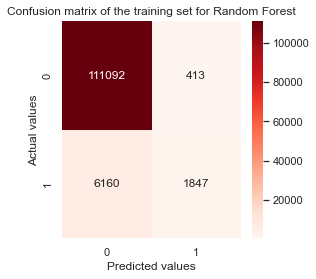

In [50]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_random_forest, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Random Forest')

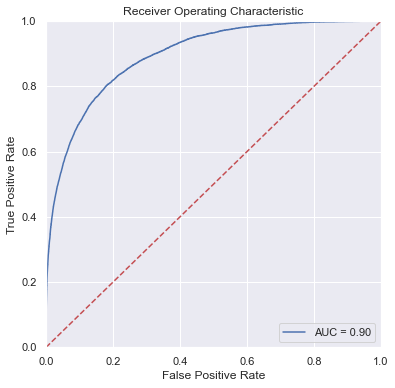

In [51]:
plot_roc(random_forest.predict_proba(X_train), y_train)

#### Logistic Regression
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [52]:
hyperparameters = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 8),'solver': ['liblinear'], 'tol': np.logspace(-4,4,8)}
algorithm = LogisticRegression(random_state = 7) 
clf_logreg = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=7),
             param_grid={'C': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'tol': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04])},
             scoring='roc_auc')

In [53]:
print('The hyperparameters are:', clf_logreg.best_params_)

The hyperparameters are: {'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.019306977288832496}


Using these hyperparameters to train our Logistic Regression algorithm:

In [54]:
logreg = LogisticRegression(C = clf_logreg.best_params_['C'], solver = clf_logreg.best_params_['solver'], 
                            penalty = clf_logreg.best_params_['penalty'], tol = clf_logreg.best_params_['tol'],
                            random_state = 7)

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_train)
confusion_matrix_logreg = confusion_matrix(y_train, y_pred_logreg)
print('The ROC-AUC score for the Logistic Regression is', roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the Logistic Regression is 0.8290648148006587


Text(0.5, 1.0, 'Confusion matrix of the training set for Logistic Regression')

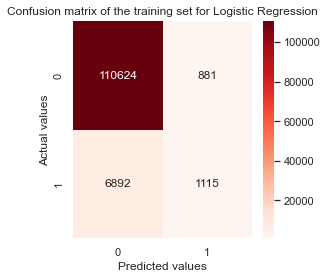

In [55]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_logreg, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Logistic Regression')

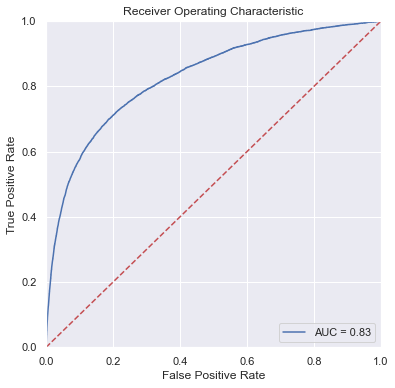

In [56]:
plot_roc(logreg.predict_proba(X_train), y_train)

#### Naive Bayes
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [57]:
hyperparameters = {'var_smoothing': np.logspace(0,-9, num=100)}
algorithm = GaussianNB()
clf_bayes = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_bayes.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [58]:
print('The hyperparameters are:', clf_bayes.best_params_)

The hyperparameters are: {'var_smoothing': 2.310129700083158e-08}


Using these hyperparameters to train our Naive Bayes Classifier:

In [59]:
naive_bayes = GaussianNB(var_smoothing = clf_bayes.best_params_['var_smoothing'])
naive_bayes.fit(X_train, y_train)

y_pred_naive_bayes = naive_bayes.predict(X_train)
confusion_matrix_naive_bayes = confusion_matrix(y_train, y_pred_naive_bayes)
print('The ROC-AUC score for the Naive Bayes Classifier is', roc_auc_score(y_train, naive_bayes.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the Naive Bayes Classifier is 0.8377956360513147


Text(0.5, 1.0, 'Confusion matrix of the training set for Naive Bayes')

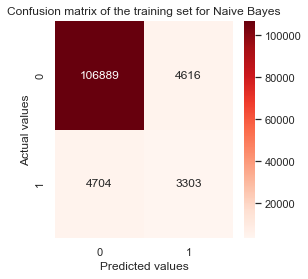

In [60]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_naive_bayes, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Naive Bayes')

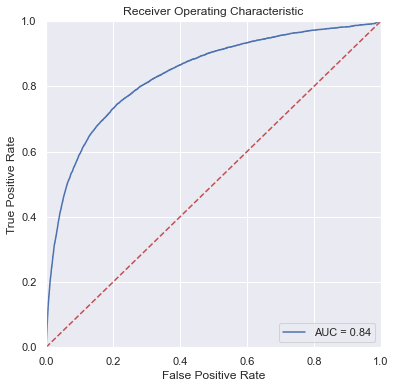

In [61]:
plot_roc(naive_bayes.predict_proba(X_train), y_train)

#### AdaBoost
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [62]:
hyperparameters = {'n_estimators':[10, 100, 500], 'learning_rate':[0.01, 0.1]}
algorithm = AdaBoostClassifier(random_state = 7) 
clf_adaboost = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_adaboost.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=7),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [10, 100, 500]},
             scoring='roc_auc')

In [63]:
print('The hyperparameters are:', clf_adaboost.best_params_)

The hyperparameters are: {'learning_rate': 0.1, 'n_estimators': 500}


Using these hyperparameters to train our AdaBoost Classifier:

In [64]:
ada_boost = AdaBoostClassifier(n_estimators = clf_adaboost.best_params_['n_estimators'],
                               learning_rate = clf_adaboost.best_params_['learning_rate'])

ada_boost.fit(X_train, y_train)
y_pred_ada_boost = ada_boost.predict(X_train)
confusion_matrix_ada_boost = confusion_matrix(y_train, y_pred_ada_boost)
print('The ROC-AUC score for the AdaBoost Classifier is', roc_auc_score(y_train, ada_boost.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the AdaBoost Classifier is 0.8620361722526914


Text(0.5, 1.0, 'Confusion matrix of the training set for AdaBoost')

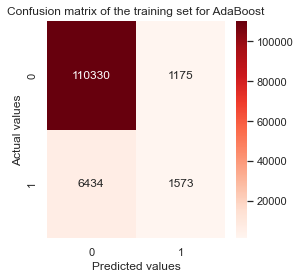

In [65]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_ada_boost, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for AdaBoost')

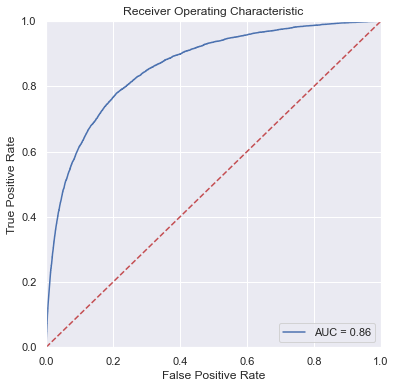

In [66]:
plot_roc(ada_boost.predict_proba(X_train), y_train)

#### k Neighbors Classifier
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [67]:
hyperparameters = {'n_neighbors': list(range(1, 11))}
algorithm = KNeighborsClassifier(n_jobs = -1)
clf_knc = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_knc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [68]:
print('The hyperparameters are:', clf_knc.best_params_)

The hyperparameters are: {'n_neighbors': 10}


Using these hyperparameters to train our k Neighbors Classifier:

In [69]:
knnc = KNeighborsClassifier(n_neighbors = clf_knc.best_params_['n_neighbors'], n_jobs = -1)
knnc.fit(X_train, y_train)
y_pred_knnc = knnc.predict(X_train)
confusion_matrix_knnc = confusion_matrix(y_train, y_pred_knnc)
print('The ROC-AUC score for the k Neighbors Classifier is', roc_auc_score(y_train, knnc.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the k Neighbors Classifier is 0.9274648835221962


Text(0.5, 1.0, 'Confusion matrix of the training set for k Neighbors Classifier')

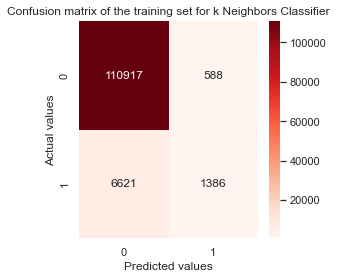

In [70]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_knnc, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for k Neighbors Classifier')

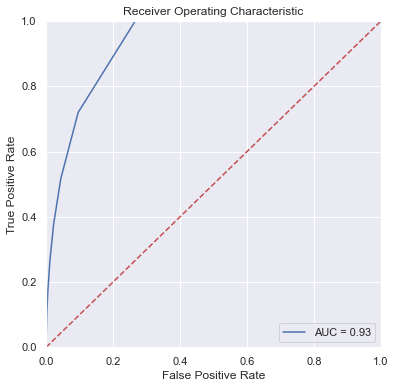

In [71]:
plot_roc(knnc.predict_proba(X_train), y_train)

#### XGBoost Classifier
Defining the hyperparameters for GridSearchCV based on the ROC-AUC score.

In [72]:
hyperparameters = {"max_depth": [4, 5, 7], "learning_rate": [0.1, 0.01], "gamma": [0.25, 1],
                   "reg_lambda": [1, 10], "scale_pos_weight": [1, 5], "subsample": [0.8], "colsample_bytree": [0.5]}
algorithm = xgb.XGBClassifier(objective="binary:logistic", random_state = 7)
clf_xgb = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'roc_auc', cv = 5)
clf_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [73]:
print('The hyperparameters are:', clf_xgb.best_params_)

The hyperparameters are: {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.8}


Using these hyperparameters to train our XGBoost Classifier:

In [74]:
xgboost_classifier = xgb.XGBClassifier(max_depth = clf_xgb.best_params_['max_depth'], gamma = clf_xgb.best_params_['gamma'],
                        learning_rate = clf_xgb.best_params_['learning_rate'],
                        reg_lambda = clf_xgb.best_params_['reg_lambda'], 
                        scale_pos_weight = clf_xgb.best_params_['scale_pos_weight'],
                        subsample = clf_xgb.best_params_['subsample'],
                        colsample_bytree = clf_xgb.best_params_['colsample_bytree'], 
                        objective="binary:logistic", random_state = 7)

xgboost_classifier.fit(X_train, y_train)
y_pred_xgboost_classifier = xgboost_classifier.predict(X_train)
confusion_matrix_xgboost_classifier = confusion_matrix(y_train, y_pred_xgboost_classifier)
print('The ROC-AUC score for the XGBoost Classifier is',roc_auc_score(y_train, xgboost_classifier.predict_proba(X_train)[:, 1]))

The ROC-AUC score for the XGBoost Classifier is 0.8703727563793098


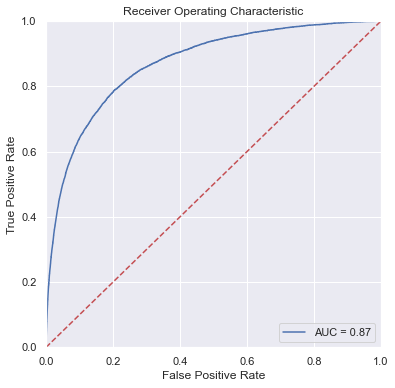

In [75]:
plot_roc(xgboost_classifier.predict_proba(X_train), y_train)

Text(0.5, 1.0, 'Confusion matrix of the training set for XGBoost Classifier')

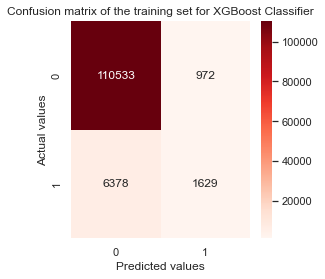

In [76]:
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_xgboost_classifier, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for XGBoost Classifier')

## Evaluating the models on the test set
Once our test data has been preprocessed by using the function preprocessing_data, we proceed to compare the ROC-AUC scores.
#### Decision Tree Classifier

The ROC-AUC score for the test data by using Decision Tree Classifier is 0.85


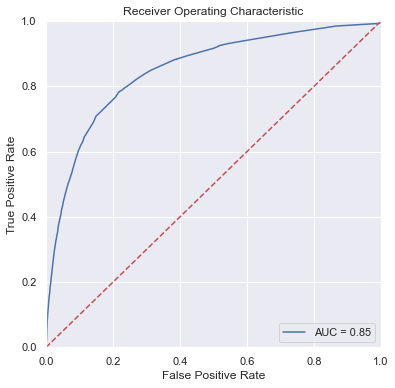

Text(0.5, 1.0, 'Confusion matrix of the training set for Decision Tree')

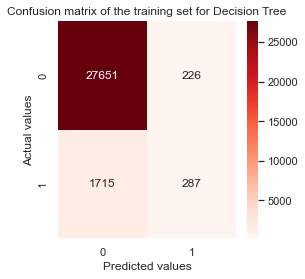

In [93]:
#Calling the decision tree classifier
y_test_pred_decision_tree = decision_tree.predict(X_test)

#ROC-AUC score
roc_auc_score_test_decision_tree = roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using Decision Tree Classifier is', round(roc_auc_score_test_decision_tree,2))

#ROC curve
plot_roc(decision_tree.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_decision_tree = confusion_matrix(y_test, y_test_pred_decision_tree)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_decision_tree, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Decision Tree')

#### Random Forest

The ROC-AUC score for the test data by using Random Forest is 0.87


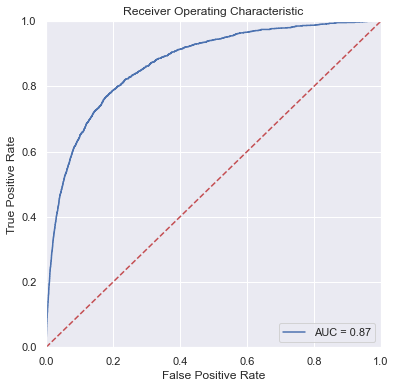

Text(0.5, 1.0, 'Confusion matrix of the training set for Random Forest')

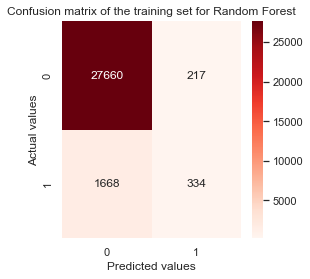

In [94]:
#Calling the random forest classifier
y_test_pred_random_forest = random_forest.predict(X_test)

#ROC-AUC score
roc_auc_score_test_random_forest = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using Random Forest is', round(roc_auc_score_test_random_forest,2))

#ROC curve
plot_roc(random_forest.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_random_forest = confusion_matrix(y_test, y_test_pred_random_forest)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_random_forest, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Random Forest')

#### Logistic Regression

The ROC-AUC score for the test data by using Logistic Regression is 0.84


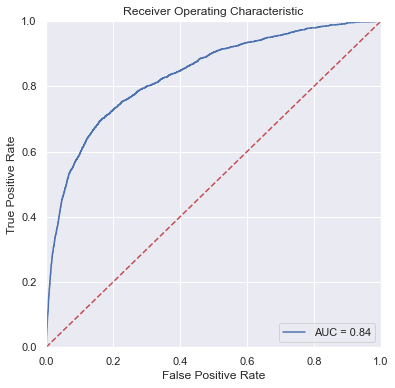

Text(0.5, 1.0, 'Confusion matrix of the training set for Logistic Regression')

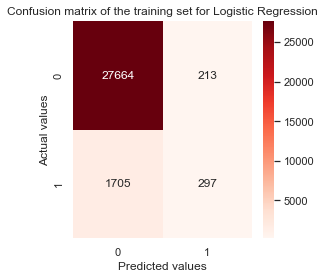

In [95]:
#Calling the logistic regression classifier
y_test_pred_logreg = logreg.predict(X_test)

#ROC-AUC score
roc_auc_score_test_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using Logistic Regression is', round(roc_auc_score_test_logreg,2))

#ROC curve
plot_roc(logreg.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_logreg = confusion_matrix(y_test, y_test_pred_logreg)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_logreg, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Logistic Regression')

#### Naive Bayes

The ROC-AUC score for the test data by using Naive Bayes is 0.85


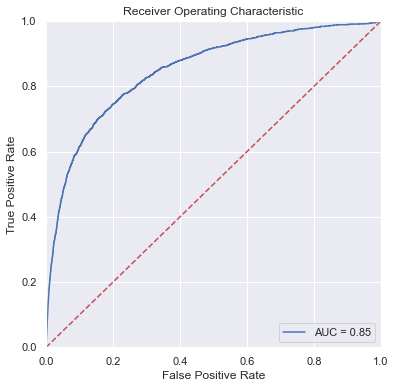

Text(0.5, 1.0, 'Confusion matrix of the training set for Naive Bayes')

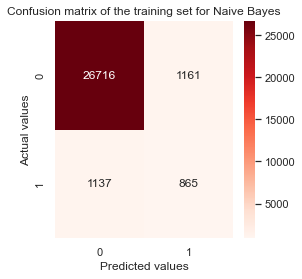

In [96]:
#Calling the naive bayes classifier
y_test_pred_naive_bayes = naive_bayes.predict(X_test)

#ROC-AUC score
roc_auc_score_test_naive_bayes = roc_auc_score(y_test, naive_bayes.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using Naive Bayes is', round(roc_auc_score_test_naive_bayes,2))

#ROC curve
plot_roc(naive_bayes.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_naive_bayes = confusion_matrix(y_test, y_test_pred_naive_bayes)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_naive_bayes, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for Naive Bayes')

#### AdaBoost

The ROC-AUC score for the test data by using AdaBoost is 0.87


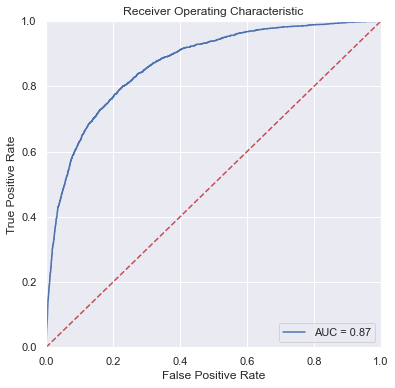

Text(0.5, 1.0, 'Confusion matrix of the training set for AdaBoost')

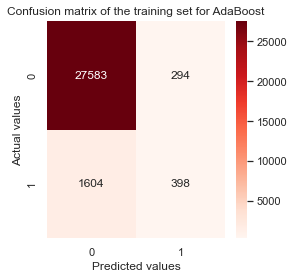

In [97]:
#Calling the ada boost classifier
y_test_pred_ada_boost = ada_boost.predict(X_test)

#ROC-AUC score
roc_auc_score_test_ada_boost = roc_auc_score(y_test, ada_boost.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using AdaBoost is', round(roc_auc_score_test_ada_boost,2))

#ROC curve
plot_roc(ada_boost.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_ada_boost = confusion_matrix(y_test, y_test_pred_ada_boost)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_ada_boost, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for AdaBoost')

#### k Neighbors Classifier

The ROC-AUC score for the test data by using k Neighbors Classifier is 0.79


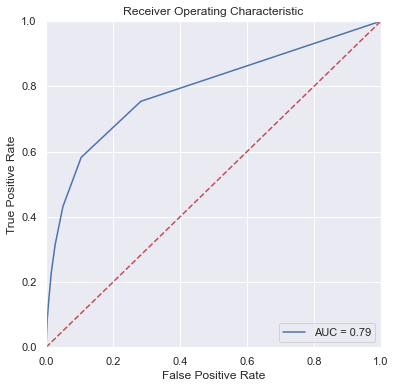

Text(0.5, 1.0, 'Confusion matrix of the training set for k Neighbors Classifier')

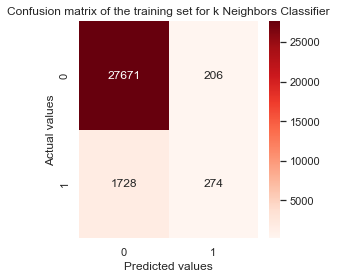

In [98]:
#Calling the k neighbors classifier
y_test_pred_knnc = knnc.predict(X_test)

#ROC-AUC score
roc_auc_score_test_knnc = roc_auc_score(y_test, knnc.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using k Neighbors Classifier is', round(roc_auc_score_test_knnc,2))

#ROC curve
plot_roc(knnc.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_knnc = confusion_matrix(y_test, y_test_pred_knnc)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_knnc, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for k Neighbors Classifier')

#### XGBoost Classifier

The ROC-AUC score for the test data by using XGBoost Classifier is 0.87


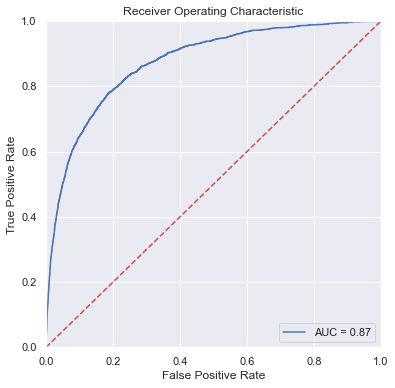

Text(0.5, 1.0, 'Confusion matrix of the training set for XGBoost Classifier')

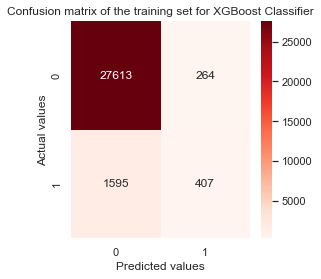

In [99]:
#Calling the XGBoost classifier
y_test_pred_xgboost_classifier = xgboost_classifier.predict(X_test)

#ROC-AUC score
roc_auc_score_test_xgboost_classifier = roc_auc_score(y_test, xgboost_classifier.predict_proba(X_test)[:, 1])
print('The ROC-AUC score for the test data by using XGBoost Classifier is', round(roc_auc_score_test_xgboost_classifier,2))

#ROC curve
plot_roc(xgboost_classifier.predict_proba(X_test), y_test)

#Confusion matrix
confusion_matrix_test_xgboost_classifier = confusion_matrix(y_test, y_test_pred_xgboost_classifier)
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test_xgboost_classifier, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])

# labels, title and ticks
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of the training set for XGBoost Classifier')

#### Selecting the best model:
The following table shows the ROC-AUC scores which were obtained for each candidate on both training and test sets. We know that GINI score can be obtained from the ROC-AUC score: $GINI = 2*AUC -1$. This metric is also shown. With all these results in hand, we will choose our best model.

In [100]:
nomes = ['Algorithm', 'ROC-AUC Score of Training Data', 'ROC-AUC Score of Test Data', 'GINI Score of Test Data']
tabela = [['Decision Tree', round(roc_auc_score(y_train, decision_tree.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_decision_tree,2), 2*round(roc_auc_score_test_decision_tree,2)-1],
        ['Random Forest', round(roc_auc_score(y_train, random_forest.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_random_forest,2), 2*round(roc_auc_score_test_random_forest,2)-1],
        ['Logistic Regression', round(roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_logreg,2), 2*round(roc_auc_score_test_logreg,2)-1],
        ['Naive Bayes', round(roc_auc_score(y_train, naive_bayes.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_naive_bayes,2), 2*round(roc_auc_score_test_naive_bayes,2)-1],
        ['AdaBoost', round(roc_auc_score(y_train, ada_boost.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_ada_boost,2), 2*round(roc_auc_score_test_ada_boost,2)-1],
        ['k Neighbors Classifier', round(roc_auc_score(y_train, knnc.predict_proba(X_train)[:, 1]),2), round(roc_auc_score_test_knnc,2), 2*round(roc_auc_score_test_knnc,2)-1],
        ['XGBoost', round(roc_auc_score(y_train, xgboost_classifier.predict_proba(X_train)[:, 1]),2) , round(roc_auc_score_test_xgboost_classifier,2), 2*round(roc_auc_score_test_xgboost_classifier,2)-1]]
print(tabulate(tabela, headers = nomes, tablefmt="github"))

| Algorithm              |   ROC-AUC Score of Training Data |   ROC-AUC Score of Test Data |   GINI Score of Test Data |
|------------------------|----------------------------------|------------------------------|---------------------------|
| Decision Tree          |                             0.86 |                         0.85 |                      0.7  |
| Random Forest          |                             0.9  |                         0.87 |                      0.74 |
| Logistic Regression    |                             0.83 |                         0.84 |                      0.68 |
| Naive Bayes            |                             0.84 |                         0.85 |                      0.7  |
| AdaBoost               |                             0.86 |                         0.87 |                      0.74 |
| k Neighbors Classifier |                             0.93 |                         0.79 |                      0.58 |
| XGBoost                |      

Therefore, we choose Random Forest as our final model. With this model, we proceed to create credit scores to group individual by similar characteristics. The process will be the following:
- Append the probabilities as a new feature in the training data.
- Multiply the probabilities by 1000 so our credit scores are scaled from 0 to 1000, where the best clients have the lower scores and the clients who present a risk have a higher score.
- We will divide the scores in 10 equal-sized buckets by using the qcut command.

In [112]:
df_credit_score = pd.DataFrame(X_train, columns = features)
df_credit_score['score'] = 1000*random_forest.predict_proba(X_train)[:,1]
df_credit_score['intervals'] = pd.qcut(df_credit_score['score'], 10)

#Visualizing the score intervals
df_credit_score['intervals'].value_counts(normalize = True)

(3.016, 6.527]       0.100007
(172.34, 872.803]    0.100007
(6.527, 9.798]       0.099998
(9.798, 12.642]      0.099998
(12.642, 16.21]      0.099998
(16.21, 22.252]      0.099998
(22.252, 33.345]     0.099998
(33.345, 55.156]     0.099998
(55.156, 85.885]     0.099998
(85.885, 172.34]     0.099998
Name: intervals, dtype: float64

We observe that each score interval contains roughly 10% of the toal clients. From best to worst, the score intervals are: [0, 3.016), [3.016, 6.527), [6.527, 9.798), [9.798, 12.642), [12.642, 16.21), [16.21, 22.252), [22.252, 33.345), [33.345, 55.156), [55.156, 85.885), [85.885, 172.34), [172.34, 872.803), [872.803, 1000].

These score intervals allow us to adopt some policies. For example, if we are a company with high risk appetite, i.e., we are willing to accept clients with high default probabilities in order to increase our expected incomes. On the other hand, if our company is well established in the market, then we can be more selective and grant loans to clients with good credit scores. As an example, let us set a probability threshold, or equivalently, a score thresshold. If we set our score threshold at 33.345, then we are rejecting clients with a score higher than it and, therefore, we are accepting 90% of the clients for this training set. In this way, we have risk appetite and we reject a small amount of clients.

We can group the intervals into tiers so that we facilitate the interpretation of our intervals:

S Tier: From 0 to 6.527. These are the best clients, only the 10%.

A Tier: From 6.527 to 16.21. These clients exhibit good credit behavior, barely 30%.

B Tier: From 16.21 to 55.156. Average clients, they can still have access to loans, approximantely 30%.

C Tier: From 55.156 to 172.34. These clients are below average and may represent a risk but, according to our risk appetite, they can have access to a loan, approximately 20%.

F Tier: From 172.34 to 1000. These are the worst clients, they will be rejected according to our policy, barely 10%.

This model can be improved by exploring neural networks as potential classification solvers. Also, it could be interesting if the scores can be improved by balancing the target.

Finally, we  will use out test data to assign a score interval (and consequently a Tier) according to our model.

In [117]:
df_test_credit_score = pd.DataFrame(X_test, columns = features)
df_test_credit_score['score'] = 1000*random_forest.predict_proba(X_test)[:,1]
df_test_credit_score['intervals'] = pd.cut(1000*random_forest.predict_proba(X_test)[:,1], bins = [0, 3.016, 6.527, 9.798,
                                    12.642, 16.21, 22.252, 33.345, 55.156, 85.885, 172.34, 872.803, 1000])
df_test_credit_score

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,score,intervals
0,0.002994,0.409091,0.000000,0.617157,0.576143,0.694834,0.0,0.17297,0.0,0.05,12.417748,"(9.798, 12.642]"
1,0.001503,0.340909,0.166667,0.023720,0.632402,0.609414,0.0,0.17297,0.0,0.10,38.272782,"(33.345, 55.156]"
2,0.016433,0.295455,0.000000,0.016625,0.608876,0.509975,0.0,0.17297,0.0,0.15,14.531953,"(12.642, 16.21]"
3,0.002827,0.193182,0.000000,0.610309,0.576143,0.394708,0.0,0.17297,0.0,0.00,9.784016,"(6.527, 9.798]"
4,0.026230,0.556818,0.000000,0.015196,0.575894,0.538861,0.0,0.00000,0.0,0.00,13.201683,"(12.642, 16.21]"
...,...,...,...,...,...,...,...,...,...,...,...,...
29874,0.005535,0.397727,0.000000,0.007873,0.562417,0.477227,0.0,0.00000,0.0,0.00,8.637011,"(6.527, 9.798]"
29875,0.001181,0.443182,0.000000,0.027970,0.564663,0.509975,0.0,0.27415,0.0,0.00,8.852101,"(6.527, 9.798]"
29876,0.005396,0.409091,0.000000,0.507429,0.576143,0.588074,0.0,0.17297,0.0,0.00,9.019106,"(6.527, 9.798]"
29877,0.048117,0.454545,0.000000,0.016008,0.557684,0.339983,0.0,0.00000,0.0,0.05,43.470823,"(33.345, 55.156]"


In [118]:
df_test_credit_score['intervals'].value_counts(normalize = True)

(172.34, 872.803]    0.103015
(22.252, 33.345]     0.102346
(16.21, 22.252]      0.101509
(12.642, 16.21]      0.101442
(9.798, 12.642]      0.100706
(85.885, 172.34]     0.100505
(55.156, 85.885]     0.098698
(3.016, 6.527]       0.098363
(33.345, 55.156]     0.097192
(6.527, 9.798]       0.096221
(0.0, 3.016]         0.000000
(872.803, 1000.0]    0.000000
Name: intervals, dtype: float64

Therefore, our model assigned interval scores to new clients for the test data.